In [33]:
import nest_asyncio
nest_asyncio.apply()

from hddCRP.modelBuilder import cdCRP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statannotations.Annotator import Annotator
from sklearn.metrics import roc_auc_score

import itertools

from pandas.api.types import CategoricalDtype
import os


In [34]:
overwrite_existing_results = False
results_directory = "Results/population/LOO/"

if(not os.path.exists(results_directory)):
    os.makedirs(results_directory)

data_filename = 'data/Data_turns_all_by_session.pkl';
with open(data_filename, 'rb') as data_file:
    data = pickle.load(data_file)

groups = ["uniform", "diverse"]
print("groups = " + str(groups))

session_numbers = None#[1]; # index by 1
number_of_trials    = 100;

action_labels = [0,1,2]

groups = ['uniform', 'diverse']


In [35]:
def run_fit(stan_seed, sequences_c, session_types_c, subject_labels_c, population_labels_c, subject_label, context_depth, nback_depth):
    model = cdCRP(sequences_c,
                    session_labels=session_types_c,
                    subject_labels=subject_labels_c,
                    population_labels=population_labels_c,
                    possible_observations=action_labels);
    model.same_nback_depth = nback_depth
    model.context_depth = context_depth

    model.build(random_seed=stan_seed);
    model.fit_model()

    fit_df  = model.fit.to_frame()
    summary_df = model.fit_summary()

    fit_df["loo_subject"]   = subject_label
    summary_df["loo_subject"] = subject_label

    if(session_numbers is None):
        summary_df["number_of_trials"] = number_of_trials
        summary_df["start_session_C"]  = pd.NA
        summary_df["end_session_C"]    = pd.NA
        fit_df["number_of_trials"] = number_of_trials
        fit_df["start_session_C"]  = pd.NA
        fit_df["end_session_C"]    = pd.NA
    else:
        start_session = np.min(session_numbers)
        end_session = np.max(session_numbers)
        summary_df["number_of_trials"] = pd.NA
        summary_df["start_session_C"]  = start_session
        summary_df["end_session_C"]    = end_session
        fit_df["number_of_trials"] = pd.NA
        fit_df["start_session_C"]  = start_session
        fit_df["end_session_C"]    = end_session
    return fit_df, summary_df


In [36]:
def xval_sequence(seq, fit_df, context_depth, nback_depth):
    Y = np.array(seq,dtype=float);
    N = Y.size

    deltas = np.arange(0,N)[:,np.newaxis] - np.arange(0,N)[np.newaxis,:]

    is_prev = deltas > 0;
    is_same = (Y[:,np.newaxis] == Y[np.newaxis,:])
    

    ctx = Y.copy()
    A = np.zeros((N,N),dtype=int)
    cd = np.zeros((N,N,context_depth))
    for depth in range(context_depth):
        ctx = np.roll(ctx,1)
        ctx[0] = np.nan
        A = (ctx[:,np.newaxis] != ctx[np.newaxis,:]) | A
        cd[:,:,depth] = np.tril(A,-1);


    if(nback_depth > 0):
        ctx = np.roll(Y.copy(), 1)
        ctx[0] = np.nan
        sb = Y == ctx
    else:
        sb = 0;
    
    if(fit_df is None):
        print(Y[:5])
        print(deltas[:5,:5])
        print(is_prev[:5,:5])
        print(is_same[:5,:5])
        for depth in range(context_depth):
            print(cd[:5,:5,depth])
        if(nback_depth > 0):
            print(sb[:5])
        return
       

    M = len(action_labels)

    def compute_log_p(df_row):
        tau = df_row["timeconstant_within_session_C"]
        alpha = df_row["alpha"]
        

        if(nback_depth > 0):
            repeat_bias_1_back_0 = df_row["repeat_bias_1_back"]
            BaseMeasure = (sb * (repeat_bias_1_back_0-1.0) + 1.0) / (repeat_bias_1_back_0 + (M-1.0));
            BaseMeasure[0] = 1.0/M;
        else:
            BaseMeasure = 1.0/M;
        if(context_depth > 0):
            C = np.array([df_row[f"context_similarity_depth_{xx}"] for xx in range(1,context_depth+1)])
            cm = np.sum(np.log(1.0-C[np.newaxis,np.newaxis,:]) * cd, axis=2)
        else:
            cm = 0;
        X = np.exp(-deltas/tau + cm) * is_prev
        Y = X * is_same

        log_P = np.log(Y.sum(axis=1) + alpha*BaseMeasure) - np.log(X.sum(axis=1) + alpha)
        return log_P.sum()

    return fit_df.apply(compute_log_p, axis=1)
xval_sequence([1,2,1,2,0,1,0],None,2,1)

[1. 2. 1. 2. 0.]
[[ 0 -1 -2 -3 -4]
 [ 1  0 -1 -2 -3]
 [ 2  1  0 -1 -2]
 [ 3  2  1  0 -1]
 [ 4  3  2  1  0]]
[[False False False False False]
 [ True False False False False]
 [ True  True False False False]
 [ True  True  True False False]
 [ True  True  True  True False]]
[[ True False  True False False]
 [False  True False  True False]
 [ True False  True False False]
 [False  True False  True False]
 [False False False False  True]]
[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 0.]]
[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0.]]
[False False False False False]


In [37]:

sequences = []
session_types = []
subject_labels = []
population_labels = []
for group in groups:
    subs = data["group_definition"][group];
    subs.sort()
    for subject_p in subs:
        sequences_0 = data["data"][subject_p]["data"]; # turns in each session
        session_types_0 = data["data"][subject_p]["task"] # which maze

        
        if(session_numbers is None):
            ii = list(np.where(np.array(session_types_0)=='C')[0])
            seqs_c = [sequences_0[xx] for xx in ii]
            seqs_c = list(itertools.chain.from_iterable(seqs_c))
            sequences += [seqs_c[:number_of_trials]]
            session_types += ['C']
            subject_labels += [subject_p]
            population_labels += [group]
        else:
            ii = list(np.where(np.array(session_types_0)=='C')[0][np.array(session_numbers)-1])
            sequences     += [sequences_0[xx] for xx in ii]
            session_types += [session_types_0[xx] for xx in ii]
            subject_labels += [subject_p] * len(ii)
            population_labels += [group]* len(ii)
            if(len(ii) > 1):
                raise ValueError("only should do one sequence per subject")
if(session_numbers is None):
    print(f"Sequences of {number_of_trials} trials")
else:
    print(f"WARNING: Using sessions {session_numbers}")

population_labels

Sequences of 100 trials


['uniform',
 'uniform',
 'uniform',
 'uniform',
 'uniform',
 'uniform',
 'uniform',
 'uniform',
 'uniform',
 'uniform',
 'diverse',
 'diverse',
 'diverse',
 'diverse',
 'diverse',
 'diverse',
 'diverse',
 'diverse',
 'diverse']

In [38]:
if(session_numbers is None):
    fit_file = f"{results_directory}/fits_trials_{number_of_trials}"
    fit_summary_file = f"{results_directory}/fit_summary_trials_{number_of_trials}"
    seed_offset = number_of_trials
    xval_file = f"{results_directory}/xval_trials_{number_of_trials}"
else:
    start_session = np.min(session_numbers)
    end_session = np.max(session_numbers)
    fit_file = f"{results_directory}/fits_session_{start_session}"
    fit_summary_file = f"{results_directory}/fit_summary_session_{start_session}"
    if(end_session != start_session):
        fit_file += f"_to_{start_session}"
        fit_summary_file  += f"_to_{start_session}"
    seed_offset = start_session
    xval_file = f"{results_directory}/xval_session_{start_session}"


fit_file += f".pkl"
fit_summary_file += f".pkl"
xval_file += f".pkl"


if(not os.path.isfile(xval_file) or overwrite_existing_results):
    # data_fits = pd.DataFrame()
    # data_fit_metrics = pd.DataFrame()
    xval_df = pd.DataFrame()
    for nback_depth in range(2):
        for context_depth in range(3):
            for subject_index, subject in enumerate(subject_labels):
                population = population_labels[subject_index];
                print(f"subject {subject} in group {population}, cd = {context_depth}, nb = {nback_depth}")

                stan_seed = (subject_index+1) * 1000 + seed_offset
                sequences_c          = [xx for (xx,yy,zz) in zip(sequences,         subject_labels, population_labels) if ((yy != subject) and (zz == population)) ]
                session_types_c      = [xx for (xx,yy,zz) in zip(session_types,     subject_labels, population_labels) if ((yy != subject) and (zz == population)) ]
                subject_labels_c     = [xx for (xx,yy,zz) in zip(subject_labels,    subject_labels, population_labels) if ((yy != subject) and (zz == population)) ]
                population_labels_c  = [xx for (xx,yy,zz) in zip(population_labels, subject_labels, population_labels) if ((yy != subject) and (zz == population)) ]
                subject_label = subject
                print(f"fitting with {subject_labels_c}, cd = {context_depth}, nb = {nback_depth}")

                fit_df, summary_df = run_fit(stan_seed, sequences_c, session_types_c, subject_labels_c, population_labels_c, subject_label, context_depth, nback_depth)

                # data_fit_metrics = pd.concat([data_fit_metrics,summary_df], copy=False)
                # data_fits        = pd.concat([data_fits,fit_df], copy=False)'

                test_seq = sequences[subject_labels.index(subject)]
                ts = xval_sequence(test_seq, fit_df, context_depth, nback_depth)
                df_c = pd.DataFrame({"log_likelihood" : ts, "subject" : subject, "train_condition" : "LOO", "nback" : nback_depth, "context" : context_depth})
                xval_df        = pd.concat([xval_df,df_c], copy=False)
            for group_index, group in enumerate(groups):
                print(f"population {group}")

                stan_seed = (group_index+1) * 10000 + seed_offset
                sequences_c          = [xx for (xx,yy,zz) in zip(sequences,         subject_labels, population_labels) if (zz == group) ]
                session_types_c      = [xx for (xx,yy,zz) in zip(session_types,     subject_labels, population_labels) if (zz == group) ]
                subject_labels_c     = [xx for (xx,yy,zz) in zip(subject_labels,    subject_labels, population_labels) if (zz == group) ]
                population_labels_c  = [xx for (xx,yy,zz) in zip(population_labels, subject_labels, population_labels) if (zz == group) ]
                subject_label = f"POPULATION_{group}"
                print(f"fitting with {subject_labels_c}")

                fit_df, summary_df = run_fit(stan_seed, sequences_c, session_types_c, subject_labels_c, population_labels_c, subject_label, context_depth, nback_depth)

                # data_fit_metrics = pd.concat([data_fit_metrics,summary_df], copy=False)
                # data_fits        = pd.concat([data_fits,fit_df], copy=False)'

                for test_seq, subject in zip(sequences_c, subject_labels_c):
                    ts = xval_sequence(test_seq, fit_df, context_depth, nback_depth)
                    df_c = pd.DataFrame({"log_likelihood" : ts, "subject" : subject, "train_condition" : "train", "nback" : nback_depth, "context" : context_depth})
                    xval_df        = pd.concat([xval_df,df_c], copy=False)

                sequences_tst          = [(xx,yy) for (xx,yy,zz) in zip(sequences,      subject_labels, population_labels) if (zz != group)]

                for test_seq, subject in sequences_tst:
                    ts = xval_sequence(test_seq, fit_df, context_depth, nback_depth)
                    df_c = pd.DataFrame({"log_likelihood" : ts, "subject" : subject, "train_condition" : "cross", "nback" : nback_depth, "context" : context_depth})
                    xval_df        = pd.concat([xval_df,df_c], copy=False)


    # data_fits.to_pickle(fit_file)
    # data_fit_metrics.to_pickle(fit_summary_file)
    xval_df.to_pickle(xval_file)
else:
    print("fit file found")
    xval_df = pd.read_pickle(xval_file)

xval_df = xval_df.assign(group=(xval_df["subject"].map(lambda s : "uniform" if s[-1] == '1' else "diverse")))



fit file found


In [39]:
# plt.figure(figsize=(12,6))
# sns.boxplot(data=xval_df, x="subject", y="log_likelihood", hue="train_condition")

# g = sns.FacetGrid(data=xval_df, col="nback",  row="context", height=3, aspect=4)
# g.map(sns.boxplot, data=xval_df, x="subject", y="log_likelihood", hue="train_condition")

<Axes: xlabel='group', ylabel='log_likelihood'>

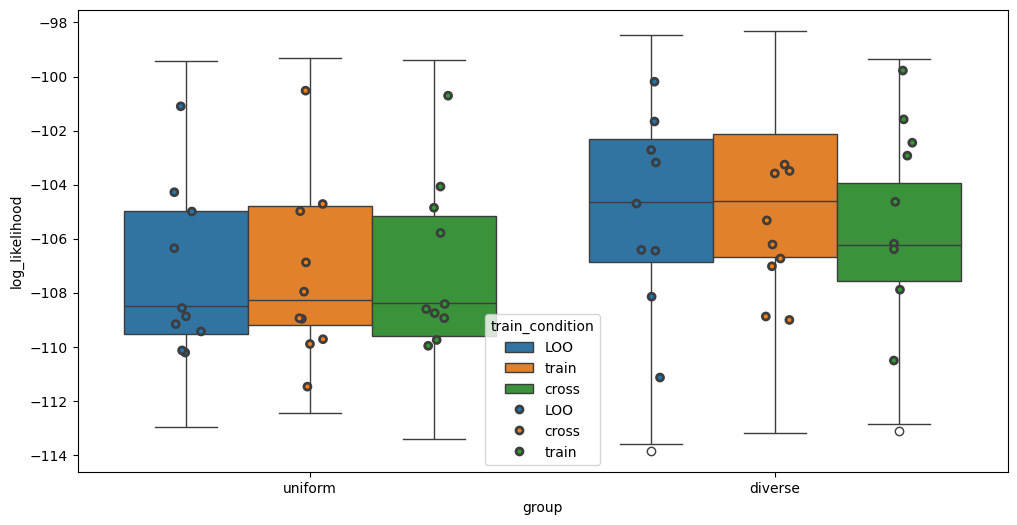

In [40]:
plt.figure(figsize=(12,6))

df_c = xval_df.query("context == 1 and nback == 1")
df_c2 = df_c.groupby(["subject", "train_condition", "group"]).agg({"log_likelihood" : "mean"}).reset_index();
sns.boxplot(data=df_c, x="group", y="log_likelihood", hue="train_condition")


sns.stripplot(data=df_c2, x="group", y="log_likelihood", hue="train_condition", dodge=1, linewidth=2)

<Axes: xlabel='subject', ylabel='log_likelihood'>

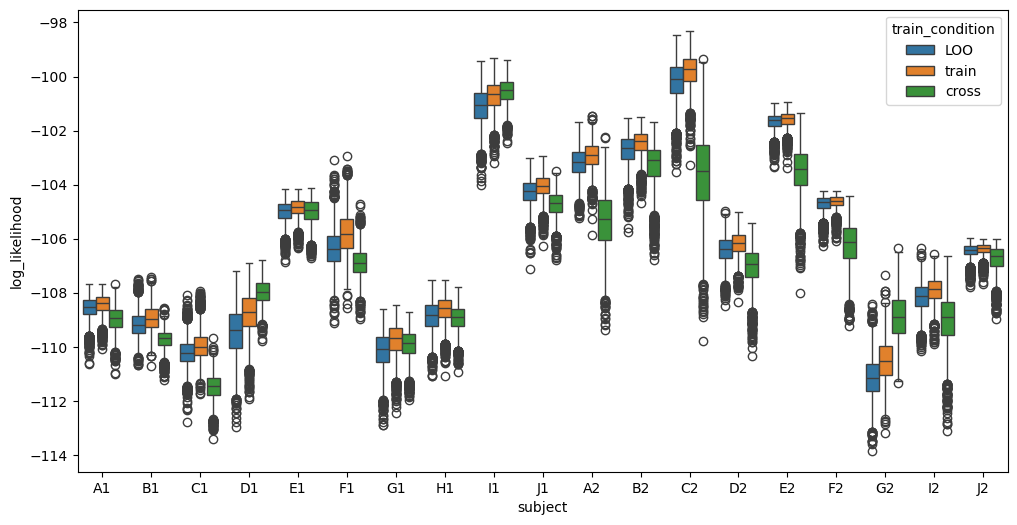

In [41]:
plt.figure(figsize=(12,6))

df_c = xval_df.query("context == 1 and nback == 1")
sns.boxplot(data=df_c, x="subject", y="log_likelihood", hue="train_condition")

group
diverse    0.990797
uniform    0.094844
Name: delta log likelihood, dtype: float64


Text(0.5, 1.0, 'within population vs between population')

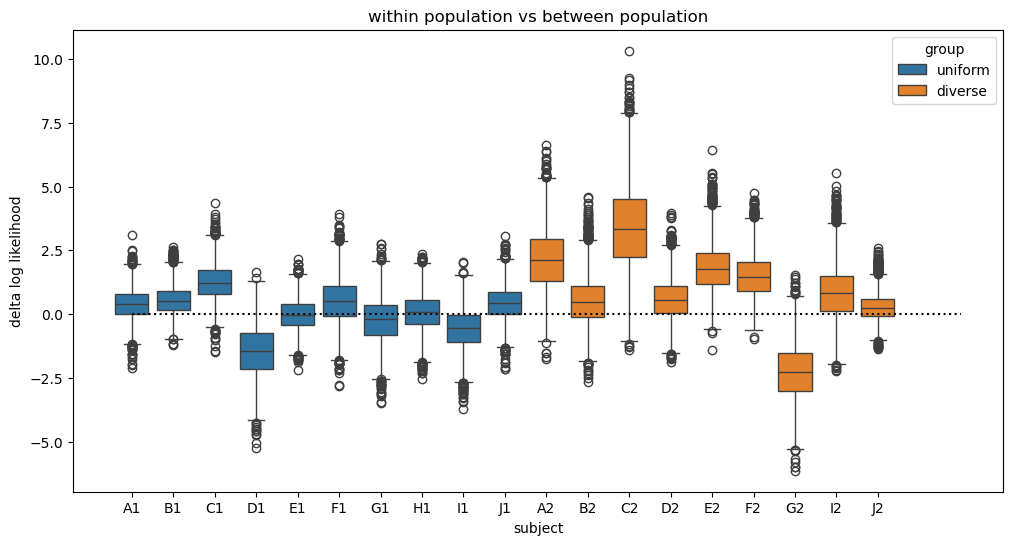

In [42]:
from scipy.stats import wilcoxon
plt.figure(figsize=(12,6))
cd = 1
nb = 1

df_c2a = xval_df.query("context == @cd and nback == @nb and train_condition == 'cross'").reset_index().set_index(["subject", "draws"])
df_c2b = xval_df.query("context == @cd and nback == @nb and train_condition == 'LOO'").reset_index().set_index(["subject", "draws"])


df_c2b["delta log likelihood"] = df_c2b["log_likelihood"] - df_c2a["log_likelihood"]
df_c2b["delta log likelihood"] = df_c2b["log_likelihood"] - df_c2a["log_likelihood"]

df_c3a = df_c2a.reset_index().groupby(["subject", "train_condition", "group"]).agg({"log_likelihood" : "mean"}).reset_index().set_index("subject");
df_c3b = df_c2b.reset_index().groupby(["subject", "train_condition", "group"]).agg({"log_likelihood" : "mean"}).reset_index().set_index("subject");

df_c3b["delta log likelihood"] = df_c3b["log_likelihood"] - df_c3a["log_likelihood"]
df_c3b["delta log likelihood"] = df_c3b["log_likelihood"] - df_c3a["log_likelihood"]


sns.boxplot(data=df_c2b, x="subject", y="delta log likelihood", hue="group")
# sns.pointplot(data=df_c3b, x="subject", y="delta log likelihood", hue="group")
plt.plot([0, 20],[0,0],'k:')

print(df_c2b.groupby("group")["delta log likelihood"].mean())
# print(df_c3b.groupby("group")["delta"].mean())

wilcoxon(df_c3b["delta log likelihood"])
plt.title("within population vs between population")

group
diverse    2.371497
uniform    0.584798
Name: delta log likelihood, dtype: float64


WilcoxonResult(statistic=16.0, pvalue=0.000644683837890625)

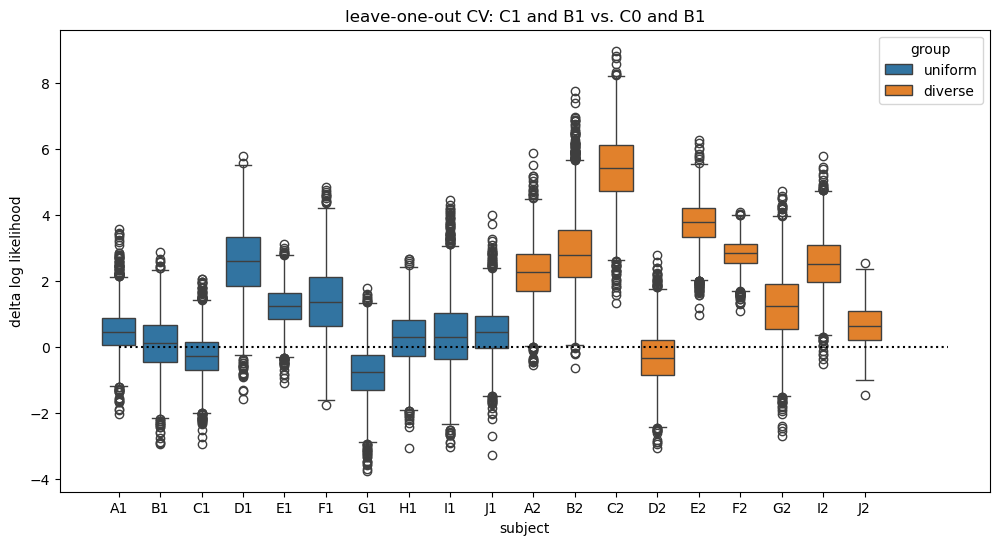

In [45]:
from scipy.stats import wilcoxon
plt.figure(figsize=(12,6))
cd1 = 0
nb1 = 1
cd2 = 1
nb2 = 1

df_c2a = xval_df.query("context == @cd1 and nback == @nb1 and train_condition == 'LOO'").reset_index().set_index(["subject", "draws"])
df_c2b = xval_df.query("context == @cd2 and nback == @nb2 and train_condition == 'LOO'").reset_index().set_index(["subject", "draws"])


df_c2b["delta log likelihood"] = df_c2b["log_likelihood"] - df_c2a["log_likelihood"]
df_c2b["delta log likelihood"] = df_c2b["log_likelihood"] - df_c2a["log_likelihood"]

df_c3a = df_c2a.reset_index().groupby(["subject", "train_condition", "group"]).agg({"log_likelihood" : "mean"}).reset_index().set_index("subject");
df_c3b = df_c2b.reset_index().groupby(["subject", "train_condition", "group"]).agg({"log_likelihood" : "mean"}).reset_index().set_index("subject");

df_c3b["delta log likelihood"] = df_c3b["log_likelihood"] - df_c3a["log_likelihood"]
df_c3b["delta log likelihood"] = df_c3b["log_likelihood"] - df_c3a["log_likelihood"]


sns.boxplot(data=df_c2b, x="subject", y="delta log likelihood", hue="group")
# sns.pointplot(data=df_c3b, x="subject", y="delta", hue="group")
plt.plot([0, 20],[0,0],'k:')

print(df_c2b.groupby("group")["delta log likelihood"].mean())
# print(df_c3b.groupby("group")["delta"].mean())
plt.title(f"leave-one-out CV: C{cd2} and B{nb2} vs. C{cd1} and B{nb1}")

wilcoxon(df_c3b["delta log likelihood"])